## About Dataset
#### Context
Build a model that data arrived every 5 minutes can determines the stretch percent of stretch film on a extruderer machine line.

#### Content
The exturder machine line consists of an extruder (single or twin screw), equipped with a screen changer and a gear pump, followed by a static mixer (sometimes feeding a coextrusion feedblock that is preceded by one or more additional extruders sets as described above), feeding a flat sheet die. Raw materials pass through the exturder in an hour.

#### Acknowledgements
Stretch percent is measured in the laboratory by samples that tested two to three times every day, data is collected by manually key in in the file Y. 


### Example of exturder machine line
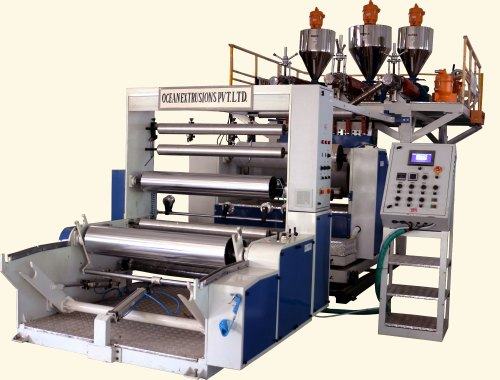

### Stretch Film Production Flow Chart
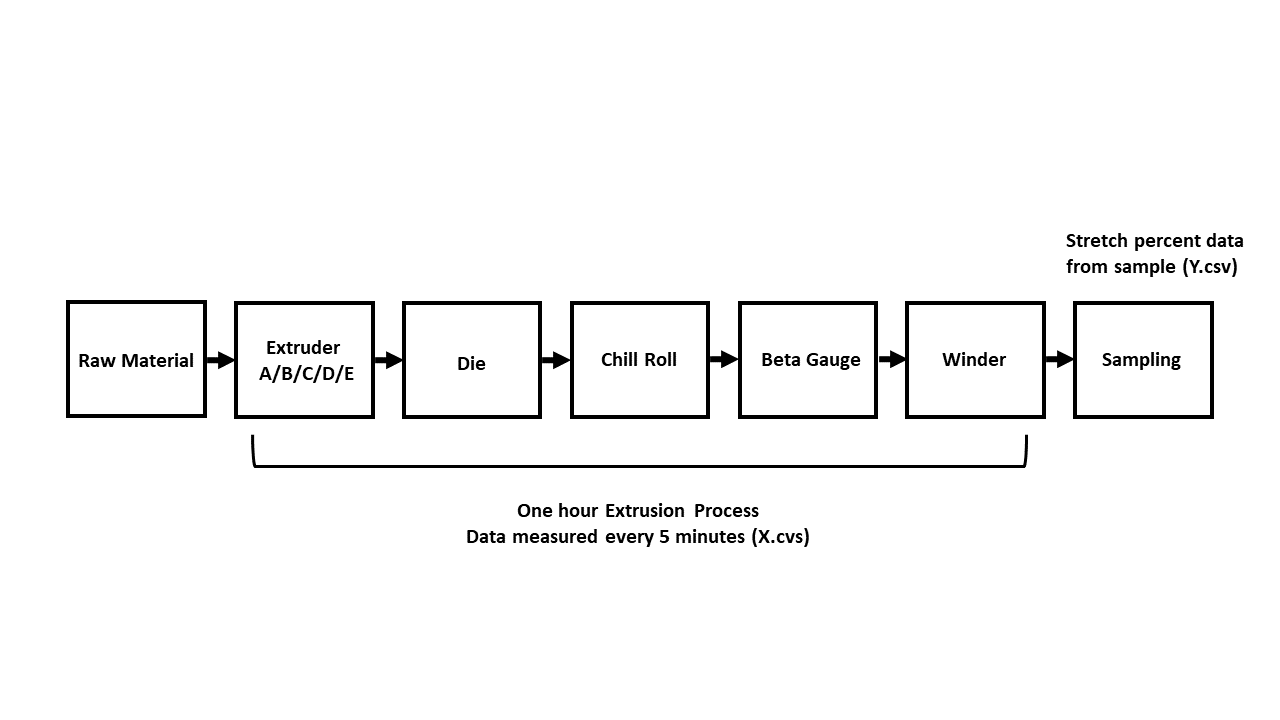

In [1]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import cross_val_score,train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stretch-percent-production/Y.csv
/kaggle/input/stretch-percent-production/sample.csv
/kaggle/input/stretch-percent-production/X.csv


#### Collect and Wrangle Data

In [2]:
X = pd.read_csv('../input/stretch-percent-production/X.csv')
Y = pd.read_csv('../input/stretch-percent-production/Y.csv')
S = pd.read_csv('../input/stretch-percent-production/sample.csv')

In [3]:
X.head()

,date,output,pri_vac_setting,sec_vac_setting,pri_vac_feedback,sec_vac_feedback,chill_1_speed,layon_speed,ext_a_rpm,ext_b_rpm,...,layon_load_start,layon_load_mid,layon_load_finish,layon_draw_diam_start,layon_draw_diam_finish,layon_draw_percent_start,layon_draw_percent_finish,index_speed_match,index_boost,index_cut_boost
0,2021/08/30 11:54:21,3566,56,61,0.93,1.11,1750,1812,69,58,...,31.0,30.0,29.0,3.68,12.0,1.0,0.95,0.35,75.0,120.0
1,2021/08/30 11:59:22,3584,56,61,0.93,1.11,1750,1811,69,58,...,31.0,30.0,29.0,3.68,12.0,1.0,0.95,0.35,75.0,120.0
2,2021/08/30 12:04:22,3536,56,61,0.93,1.11,1750,1811,69,58,...,31.0,30.0,29.0,3.68,12.0,1.0,0.95,0.35,75.0,120.0
3,2021/08/30 12:09:22,3595,56,61,0.93,1.11,1750,1811,69,58,...,31.0,30.0,29.0,3.68,12.0,1.0,0.95,0.35,75.0,120.0
4,2021/08/30 12:14:22,3420,56,61,0.93,1.11,1750,1812,69,58,...,31.0,30.0,29.0,3.68,12.0,1.0,0.95,0.35,75.0,120.0


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27190 entries, 0 to 27189
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       27190 non-null  object 
 1   output                     27190 non-null  int64  
 2   pri_vac_setting            27190 non-null  int64  
 3   sec_vac_setting            27190 non-null  int64  
 4   pri_vac_feedback           27190 non-null  float64
 5   sec_vac_feedback           27190 non-null  float64
 6   chill_1_speed              27190 non-null  int64  
 7   layon_speed                27190 non-null  int64  
 8   ext_a_rpm                  27190 non-null  int64  
 9   ext_b_rpm                  27190 non-null  int64  
 10  ext_c_rpm                  27190 non-null  int64  
 11  ext_d_rpm                  27190 non-null  int64  
 12  ext_e_rpm                  27190 non-null  int64  
 13  ext_a_output_rate          27190 non-null  flo

In [5]:
X["date"] = pd.to_datetime(X["date"])

In [6]:
X.index = X['date']

In [7]:
X = X.resample('H').mean()

In [8]:
X.reset_index(inplace=True)

In [9]:
X["date"] = pd.to_datetime(X["date"])
X["date_hour"] = X["date"].apply(lambda x: x.strftime("%Y-%m-%d-%H"))
X

,date,output,pri_vac_setting,sec_vac_setting,pri_vac_feedback,sec_vac_feedback,chill_1_speed,layon_speed,ext_a_rpm,ext_b_rpm,...,layon_load_mid,layon_load_finish,layon_draw_diam_start,layon_draw_diam_finish,layon_draw_percent_start,layon_draw_percent_finish,index_speed_match,index_boost,index_cut_boost,date_hour
0,2021-08-30 11:00:00,3575.000000,56.000000,61.000000,0.930000,1.110000,1750.00,1811.500000,69.000000,58.000000,...,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0,2021-08-30-11
1,2021-08-30 12:00:00,3544.083333,56.000000,61.000000,0.927500,1.107500,1750.00,1811.750000,69.000000,58.000000,...,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0,2021-08-30-12
2,2021-08-30 13:00:00,3548.750000,56.000000,61.000000,0.935000,1.111667,1750.00,1811.833333,69.000000,58.000000,...,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0,2021-08-30-13
3,2021-08-30 14:00:00,3553.000000,56.000000,61.000000,0.937500,1.110000,1750.00,1811.750000,69.000000,58.000000,...,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0,2021-08-30-14
4,2021-08-30 15:00:00,3568.250000,56.000000,61.000000,0.930833,1.100000,1750.00,1811.416667,69.000000,58.000000,...,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0,2021-08-30-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5806,2022-04-29 09:00:00,2898.416667,55.000000,60.000000,0.575833,0.908333,1509.00,1559.083333,58.000000,55.000000,...,32.0,31.0,3.67,12.0,1.05,1.00,0.35,75.0,125.0,2022-04-29-09
5807,2022-04-29 10:00:00,2895.166667,55.000000,60.000000,0.575000,0.908333,1509.00,1559.166667,57.833333,55.000000,...,32.0,31.0,3.67,12.0,1.05,1.00,0.35,75.0,125.0,2022-04-29-10
5808,2022-04-29 11:00:00,2891.750000,55.000000,60.000000,0.590833,0.931667,1509.00,1559.500000,57.750000,55.000000,...,32.0,31.0,3.67,12.0,1.05,1.00,0.35,75.0,125.0,2022-04-29-11
5809,2022-04-29 12:00:00,2504.166667,50.083333,55.083333,0.516667,0.815833,1305.75,1349.333333,49.000000,46.333333,...,32.0,31.0,3.67,12.0,1.05,1.00,0.35,75.0,125.0,2022-04-29-12


#### Remove outliers

In [10]:
def find_outliers_IQR(X):
    q1=X.quantile(0.05)
    q3=X.quantile(0.95)
    IQR=q3-q1
    not_outliers = X[~((X<(q1-1.5*IQR)) | (X>(q3+1.5*IQR)))]
    return not_outliers

In [11]:
noutlier = find_outliers_IQR(X[['output',
                                'pri_vac_setting', 
                                'sec_vac_setting', 
                                'pri_vac_feedback', 
                                'sec_vac_feedback',
                                'chill_1_speed', 
                                'layon_speed', 
                                'ext_b_rpm', 
                                'ext_c_rpm',
                                'ext_d_rpm',
                                'ext_e_rpm',
                                'ext_a_output_rate', 
                                'ext_b_output_rate',
                                'ext_c_output_rate', 
                                'ext_d_output_rate',                 
                                'ext_e_output_rate',                   
                                'ext_a_pres',                  
                                'ext_b_pres',                   
                                'ext_c_pres',                  
                                'ext_d_pres',                  
                                'ext_e_pres',
                                'ext_c_trim',
                                'ext_d_trim', 
                                'die_slot',
                                'plate_out_draw',
                                'sec_cooling_draw',
                                'sec_nip_draw',
                                'cast_idler_1_draw',
                                'cast_idler_2_draw',
                                'rand_1_draw',
                                'rand_2_draw',
                                'rand_3_draw',
                                'wind_infeed_draw',
                                'slit_infeed_draw',
                                'slit_outfeed_draw',
                                'trim_removal_draw',
                                'wind_idler_draw',
                                'layon_roll_chg_pres',
                                'layon_retract_pres',
                                'layon_stiff_pres',
                                'layon_diam_start',
                                'layon_diam_mid',
                                'layon_diam_finish',
                                'layon_load_start',
                                'layon_load_mid',
                                'layon_load_finish',
                                'layon_draw_diam_start',
                                'layon_draw_diam_finish',
                                'layon_draw_percent_start',
                                'layon_draw_percent_finish',
                                'index_speed_match',
                                'index_boost',
                                'index_cut_boost']])

noutlier

,output,pri_vac_setting,sec_vac_setting,pri_vac_feedback,sec_vac_feedback,chill_1_speed,layon_speed,ext_b_rpm,ext_c_rpm,ext_d_rpm,...,layon_load_start,layon_load_mid,layon_load_finish,layon_draw_diam_start,layon_draw_diam_finish,layon_draw_percent_start,layon_draw_percent_finish,index_speed_match,index_boost,index_cut_boost
0,3575.000000,56.000000,61.000000,0.930000,1.110000,1750.00,1811.500000,58.000000,75.0,78.00,...,31.0,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0
1,3544.083333,56.000000,61.000000,0.927500,1.107500,1750.00,1811.750000,58.000000,75.0,78.00,...,31.0,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0
2,3548.750000,56.000000,61.000000,0.935000,1.111667,1750.00,1811.833333,58.000000,75.0,78.00,...,31.0,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0
3,3553.000000,56.000000,61.000000,0.937500,1.110000,1750.00,1811.750000,58.000000,75.0,78.00,...,31.0,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0
4,3568.250000,56.000000,61.000000,0.930833,1.100000,1750.00,1811.416667,58.000000,75.0,78.00,...,31.0,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5806,2898.416667,55.000000,60.000000,0.575833,0.908333,1509.00,1559.083333,55.000000,52.0,59.00,...,33.0,32.0,31.0,3.67,12.0,1.05,1.00,0.35,75.0,125.0
5807,2895.166667,55.000000,60.000000,0.575000,0.908333,1509.00,1559.166667,55.000000,52.0,59.00,...,33.0,32.0,31.0,3.67,12.0,1.05,1.00,0.35,75.0,125.0
5808,2891.750000,55.000000,60.000000,0.590833,0.931667,1509.00,1559.500000,55.000000,52.0,59.00,...,33.0,32.0,31.0,3.67,12.0,1.05,1.00,0.35,75.0,125.0
5809,2504.166667,50.083333,55.083333,0.516667,0.815833,1305.75,1349.333333,46.333333,44.5,50.75,...,33.0,32.0,31.0,3.67,12.0,1.05,1.00,0.35,75.0,125.0


In [12]:
def drop_outliers_IQR(X):
    
    q1=X.quantile(0.05)
    q3=X.quantile(0.95)
    IQR=q3-q1
    outliers_dropped = noutlier.dropna().reset_index()
    
    return outliers_dropped

In [13]:
outliers_dropped = drop_outliers_IQR(X[['output',
                                        'pri_vac_setting', 
                                        'sec_vac_setting', 
                                        'pri_vac_feedback', 
                                        'sec_vac_feedback',
                                        'chill_1_speed', 
                                        'layon_speed', 
                                        'ext_b_rpm', 
                                        'ext_c_rpm',
                                        'ext_d_rpm',
                                        'ext_e_rpm',
                                        'ext_a_output_rate', 
                                        'ext_b_output_rate',
                                        'ext_c_output_rate', 
                                        'ext_d_output_rate',                  
                                        'ext_e_output_rate',                   
                                        'ext_a_pres',                  
                                        'ext_b_pres',                   
                                        'ext_c_pres',                  
                                        'ext_d_pres',                  
                                        'ext_e_pres',
                                        'ext_c_trim',
                                        'ext_d_trim', 
                                        'die_slot',
                                        'plate_out_draw',
                                        'sec_cooling_draw',
                                        'sec_nip_draw',
                                        'cast_idler_1_draw',
                                        'cast_idler_2_draw',
                                        'rand_1_draw',
                                        'rand_2_draw',
                                        'rand_3_draw',
                                        'wind_infeed_draw',
                                        'slit_infeed_draw',
                                        'slit_outfeed_draw',
                                        'trim_removal_draw',
                                        'wind_idler_draw',
                                        'layon_roll_chg_pres',
                                        'layon_retract_pres',
                                        'layon_stiff_pres',
                                        'layon_diam_start',
                                        'layon_diam_mid',
                                        'layon_diam_finish',
                                        'layon_load_start',
                                        'layon_load_mid',
                                        'layon_load_finish',
                                        'layon_draw_diam_start',
                                        'layon_draw_diam_finish',
                                        'layon_draw_percent_start',
                                        'layon_draw_percent_finish',
                                        'index_speed_match',
                                        'index_boost',
                                        'index_cut_boost']])
outliers_dropped

,index,output,pri_vac_setting,sec_vac_setting,pri_vac_feedback,sec_vac_feedback,chill_1_speed,layon_speed,ext_b_rpm,ext_c_rpm,...,layon_load_start,layon_load_mid,layon_load_finish,layon_draw_diam_start,layon_draw_diam_finish,layon_draw_percent_start,layon_draw_percent_finish,index_speed_match,index_boost,index_cut_boost
0,0,3575.000000,56.000000,61.000000,0.930000,1.110000,1750.00,1811.500000,58.000000,75.0,...,31.0,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0
1,1,3544.083333,56.000000,61.000000,0.927500,1.107500,1750.00,1811.750000,58.000000,75.0,...,31.0,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0
2,2,3548.750000,56.000000,61.000000,0.935000,1.111667,1750.00,1811.833333,58.000000,75.0,...,31.0,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0
3,3,3553.000000,56.000000,61.000000,0.937500,1.110000,1750.00,1811.750000,58.000000,75.0,...,31.0,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0
4,4,3568.250000,56.000000,61.000000,0.930833,1.100000,1750.00,1811.416667,58.000000,75.0,...,31.0,30.0,29.0,3.68,12.0,1.00,0.95,0.35,75.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,5806,2898.416667,55.000000,60.000000,0.575833,0.908333,1509.00,1559.083333,55.000000,52.0,...,33.0,32.0,31.0,3.67,12.0,1.05,1.00,0.35,75.0,125.0
2017,5807,2895.166667,55.000000,60.000000,0.575000,0.908333,1509.00,1559.166667,55.000000,52.0,...,33.0,32.0,31.0,3.67,12.0,1.05,1.00,0.35,75.0,125.0
2018,5808,2891.750000,55.000000,60.000000,0.590833,0.931667,1509.00,1559.500000,55.000000,52.0,...,33.0,32.0,31.0,3.67,12.0,1.05,1.00,0.35,75.0,125.0
2019,5809,2504.166667,50.083333,55.083333,0.516667,0.815833,1305.75,1349.333333,46.333333,44.5,...,33.0,32.0,31.0,3.67,12.0,1.05,1.00,0.35,75.0,125.0


In [14]:
X.reset_index(inplace=True)
X = X.rename(columns = {'index':'index'})

In [15]:
X = pd.merge(outliers_dropped, X[["index","date_hour"]],left_on="index",right_on="index",how="inner")

In [16]:
Y.head()

,date,stretch_percent
0,2021-08-30 08:00:00,310.0
1,2021-08-30 14:30:00,338.0
2,2021-08-30 20:00:00,329.0
3,2021-08-30 08:04:00,NaN
4,2021-08-30 02:16:00,NaN


In [17]:
import datetime

In [18]:
Y["date_shifted"] = pd.to_datetime(Y["date"]) - datetime.timedelta(hours=1)
Y["date_shifted"] = pd.to_datetime(Y["date_shifted"])
Y["date_shifted"] = Y["date_shifted"].apply(lambda x: x.strftime("%Y-%m-%d-%H"))

#### Combine X and Y datasets together

In [19]:
T = pd.merge(X,Y[["date_shifted","stretch_percent"]],left_on="date_hour",right_on="date_shifted",how="inner")

In [20]:
T.head()

,index,output,pri_vac_setting,sec_vac_setting,pri_vac_feedback,sec_vac_feedback,chill_1_speed,layon_speed,ext_b_rpm,ext_c_rpm,...,layon_draw_diam_start,layon_draw_diam_finish,layon_draw_percent_start,layon_draw_percent_finish,index_speed_match,index_boost,index_cut_boost,date_hour,date_shifted,stretch_percent
0,2,3548.750000,56.000000,61.000000,0.935000,1.111667,1750.00,1811.833333,58.000000,75.000000,...,3.68,12.0,1.0,0.95,0.35,75.0,120.0,2021-08-30-13,2021-08-30-13,338.0
1,8,3629.583333,49.666667,54.666667,0.744167,0.890000,1623.50,1681.250000,59.083333,76.083333,...,3.68,12.0,1.0,0.95,0.35,75.0,120.0,2021-08-30-19,2021-08-30-19,329.0
2,16,3698.166667,49.000000,54.000000,0.736667,0.883333,1666.00,1724.333333,61.000000,78.000000,...,3.68,12.0,1.0,0.95,0.35,75.0,120.0,2021-08-31-03,2021-08-31-03,337.0
3,20,3698.083333,49.000000,54.000000,0.742500,0.890000,1666.00,1724.500000,61.000000,78.000000,...,3.68,12.0,1.0,0.95,0.35,75.0,120.0,2021-08-31-07,2021-08-31-07,345.0
4,24,3657.666667,47.916667,52.916667,0.716667,0.858333,1651.75,1710.083333,61.916667,77.000000,...,3.68,12.0,1.0,0.95,0.35,75.0,120.0,2021-08-31-11,2021-08-31-11,354.0


In [21]:
T = T.drop(['index', "date_hour","date_shifted"],axis=1)

In [22]:
T = T.dropna()

In [23]:
S.head()

,date,stretch_percent
0,2019-04-09 08:56:00,390.0
1,2019-04-10 13:12:00,415.0
2,2019-04-11 09:11:00,334.0
3,2019-04-12 10:44:00,380.0
4,2019-07-09 14:10:00,341.0


In [24]:
S = S.replace(0, np.nan)

In [25]:
S["date_hour"] = pd.to_datetime(S["date"]).apply(lambda x: x.strftime("%Y-%m-%d-%H"))

#### Combine X and Submission data

In [26]:
V = pd.merge(X,S[["date_hour","stretch_percent"]],left_on="date_hour",right_on="date_hour",how="inner")

#### Split data and apply in machine learning models

In [27]:
x = T.drop(["stretch_percent"],axis=1)
y = T["stretch_percent"]

In [28]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
dt_model = DecisionTreeRegressor(random_state=0)

#### Use cross-validation to ckeck how models perform

In [29]:
xgb_cv =cross_val_score(xgb_model,x,y,cv=10,scoring=('neg_mean_absolute_error'))

In [30]:
print("Average XGB Cross Validation MAE: {0}".format(np.abs(xgb_cv.mean())))
print("Best XGB Cross Validation MAE: {0}".format(np.abs(xgb_cv.max())))

Average XGB Cross Validation MAE: 28.691253561179973
Best XGB Cross Validation MAE: 17.17329200538429


In [31]:
cv_dt = cross_val_score(dt_model,x,y,cv=10,scoring=('neg_mean_absolute_error'))

In [32]:
print("Average Decision Tree Cross Validation MAE: {0}".format(np.abs(cv_dt.mean())))
print("Best Decision Tree Cross Validation MAE: {0}".format(np.abs(cv_dt.max())))

Average Decision Tree Cross Validation MAE: 41.65085348506401
Best Decision Tree Cross Validation MAE: 27.710526315789473


Here I also tried to see if I can train models to get better MAE values

In [33]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [34]:
dt_model.fit(x_train,y_train)

DecisionTreeRegressor(random_state=0)

In [35]:
xgb_model.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [36]:
predictions_xgb = xgb_model.predict(x_test)
predictions_dt = dt_model.predict(x_test)

In [37]:
print("XGBoost Regressor MAE: {0}".format(mean_absolute_error(y_test,predictions_xgb)))
print("DecisionTree Regressor MAE: {0}".format(mean_absolute_error(y_test,predictions_dt)))

XGBoost Regressor MAE: 25.857489420572918
DecisionTree Regressor MAE: 30.453333333333333


The best MAE I can get is 17.17 from cross-validation, but I can get better average MAE = 25.86 here.

In [38]:
results = pd.DataFrame()
results["True"] = y_test
results["Predicted XGB"]=predictions_xgb
results["Predicted DecisionTree"]=predictions_dt

In [39]:
results

,True,Predicted XGB,Predicted DecisionTree
245,368.0,376.802765,381.0
289,348.0,361.471924,416.0
98,337.0,353.620850,343.0
166,401.0,336.022675,390.0
44,371.0,374.279572,378.0
...,...,...,...
429,370.0,363.656342,360.0
3,345.0,339.352844,329.0
382,348.0,368.054443,330.0
234,396.0,388.857574,389.0


### Submission file

In [40]:
model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(x,y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [41]:
v = V.drop(["date_hour","stretch_percent", 'index'],axis=1)

In [42]:
stretch = model.predict(v)
V["stretch_percent"] = stretch

In [43]:
V = V[["date_hour","stretch_percent"]]

In [44]:
V

,date_hour,stretch_percent
0,2022-02-17-15,309.043945
1,2022-02-17-15,309.043945
2,2022-02-22-11,361.809845
3,2022-02-22-11,361.809845
4,2022-02-22-11,361.809845
5,2022-02-22-11,361.809845
6,2022-02-22-16,359.131653
7,2022-02-23-13,358.925140
8,2022-02-23-13,358.925140
9,2022-02-23-13,358.925140


### SUMMARY
The best MAE we can achieve was MAE=17.17 from corss validation, and average MAE is 25.86. Since I don't have more stretch percent data, lacking of data will also be one of the reason I cannot train my model better. Also, I am not sure if transpose data can help to improve, so if someone knows the way can transpose the data without problem, please let me know!!!